In [47]:
import numpy as np
import pandas as pd
import re

from PIL import Image

import nltk
import string

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import unicodedata
from sklearn.metrics import classification_report, roc_curve, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks", color_codes=True)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/stuartxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stuartxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stuartxu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load the MBTI dataset

In [2]:
mbti = pd.read_csv('mbti_1.csv')

In [3]:
pd.set_option('display.max_colwidth', -1)
mbti.iloc[0].posts

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

## Text Prep

In [4]:
mbti.type.unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [5]:
def remove_accents(input_str):
    '''
    This function is to remove the accents
    '''
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

def remove_http(sentences):
    '''
    remove the URLs in the text
    '''
    sentences_ = []
    for sentence in sentences:
        sentence = re.sub(r"http\S+", "", sentence)
        sentences_.append(sentence)
    return [sent for sent in sentences_ if not sent in {"", "'"}]

def filter_tokens(sentence):
    '''
    This is to remove the stop words. Update the stop words in set stopwords2
    '''
    stopwords1 = set(stopwords.words('english'))
    stopwords2 = {"\'s","\'ve","\'re", "n't", 'INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
                  'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ', 'infj', 'entp','intp','intj',
                  'entj','enfj','infp', 'enfp','isfp','istp','isfj','istj','estp','esfp','estj','esfj'}
    stopwords_ = stopwords1.union(stopwords2)
    
    punctuation_ = set(string.punctuation)
    return([w for w in sentence if not w in stopwords_ and not w in punctuation_])

def remove_digits(sentences):
    '''
    remove the numbers in the text
    '''
    sentences_ = []
    for sentence in sentences:
        sentence = re.sub(r'[^a-zA-Z]+', ' ', sentence)
        sentences_.append(sentence)
    return [sent for sent in sentences_ if not sent in {"", "'"}]

def lemm_and_stem(sentences):
    '''
    lemmatizing and stemming the words
    '''
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    output = []
    for word_list in sentences:
        lemmatized_words = [lemmatizer.lemmatize(w) for w in word_list]
        stemmed_words = ' '.join([stemmer.stem(w) for w in lemmatized_words])
        output.append(stemmed_words)
    return output

In [6]:
def clean_data(input_str):
    accent_removed=remove_accents(input_str) #remove the accent
    sentences = accent_removed.split('|||') #split the string and get sentences
    removed_http = remove_http(sentences)
    removed_digits = remove_digits(removed_http)
    tokens = [sent for sent in map(word_tokenize, removed_digits)]
    tokens_lower = [[word.lower() for word in sentence]
                 for sentence in tokens]
    
    tokens_filtered = list(map(filter_tokens, tokens_lower))
    tokens_lemms = lemm_and_stem(tokens_filtered)

    return tokens_lemms

In [9]:
bag_of_sent = mbti.posts.apply(lambda x: clean_data(x))

In [10]:
bag_of_sent[648]

['never play unless count forc school p e lesson hope never ever rest life',
 'crook',
 'thank answer take time read post realli appreci live although read nt sj forum seem',
 'anyth may affect way answer question exampl stress time mental ill medic special life circumst use inform includ sex',
 'gay boyfriend nearli month believ make interest duo say least',
 'extrem racist homophob similar type peopl tend make mind boil also peopl deliber slow internet speed think right',
 'messi bedroom alway say clean room finish read someth forget rememb hour sometim day',
 'ye time usual anoth version sometim talk loud without realis peopl think talk somebodi els room',
 'realli excit want get hype either happi kotor amaz',
 'rare get angri annoy somebodi set trigger usual alway give hefti dose silent treatment vari degre simpli talk somebodi',
 'find lot incred bore thought tri someth like algebra make want run far away possibl sadist tormentor still think could',
 'freshli cut grass seem quit p

In [11]:
corpus = [' '.join(x) for x in bag_of_sent]

In [15]:
corpus[300]

'may pretti old joke one keep take threat say blood cover letter everyth complet immers exist hide friend tri differ person one would like real one hide lack mani experi everyon assum omg get perfect new radiohead album usual troubl get work music prefer book movi even video game felt take fairli long break someth found intens meaning get lot practic stuff done practic stuff bad except anxiou person way read situat think know right feel like right chastis though lash protect humili probabl count dark nowaday way see everyon nice kind loyal etc mean suscept way evolut wrote half seriou half comed articl subject peopl usual take serious site bought text want remov bit get delet uhhh long stori sorri read review young adult book said main charact phase one teenag year one think unbeliev anyon could attract one one find passion like find call like forc visit someon parent child flip channel one liter feel like picasso paint time sound like kind poetic thing watch movi room yesterday one go

### take a look at the type column

In [16]:
[x.lower() for x in mbti.type.unique()]

['infj',
 'entp',
 'intp',
 'intj',
 'entj',
 'enfj',
 'infp',
 'enfp',
 'isfp',
 'istp',
 'isfj',
 'istj',
 'estp',
 'esfp',
 'estj',
 'esfj']

In [17]:
def get_personality(input_mbti):
    introverted = (input_mbti[0] == 'I')
    intuitive = (input_mbti[1] == 'N')
    thinking = (input_mbti[2] == 'T')
    judgemental = (input_mbti[3] == 'J')
    return np.array([introverted, intuitive, thinking, judgemental])

In [18]:
mbti['personalities'] = mbti.type.apply(lambda x: get_personality(x))

In [19]:
mbti['introversion'] = mbti.personalities.apply(lambda x: x[0])
mbti['intuition'] = mbti.personalities.apply(lambda x: x[1])
mbti['thinking'] = mbti.personalities.apply(lambda x: x[2])
mbti['judging'] = mbti.personalities.apply(lambda x: x[3])

In [369]:
# mbti.drop('personalities', axis = 1, inplace=True)

## Myers–Briggs


                        |           | Subjective        | Objective                 |
                        |-----------|-------------------|---------------------------|
                        | Deductive | Intuition/Sensing | Introversion/Extraversion |
                        | Inductive | Feeling/Thinking  | Perception/Judging        |

In [20]:
mbti['tokens'] = corpus

In [21]:
df = mbti[['type', 'introversion', 'intuition',
       'thinking', 'judging', 'tokens']]

In [22]:
df.head()

,type,introversion,intuition,thinking,judging,tokens
0,INFJ,True,True,False,True,moment sportscent top ten play prank life chang experi life repeat today may perc experi immers last thing friend post facebook commit suicid next day rest peac hello sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth welcom stuff game set match prozac wellbrutin least thirti minut move leg mean move sit desk chair weed moder mayb tri edibl healthier altern basic come three item determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim dear favorit video game grow current favorit video game cool appear late sad someon everyon wait thought confid good thing cherish time solitud b c revel within inner world wherea time workin enjoy time worri peopl alway around yo ladi complimentari person well hey main social outlet xbox live convers even verbal fatigu quickli realli dig part ban thread requir get high backyard roast eat marshmellow backyard convers someth intellectu follow massag kiss ban mani b sentenc could think b ban watch movi corner dunc ban health class clearli taught noth peer pressur ban whole host reason two babi deer left right munch beetl middl use blood two caveman diari today latest happen design cave diari wall see pokemon world societi everyon becom optimist artist artist draw idea count form someth like signatur welcom robot rank person down self esteem cuz avid signatur artist like proud ban take room bed ya got ta learn share roach ban much thunder grumbl kind storm yep ahh old high school music heard age fail public speak class year ago sort learn could better posit big part failur overload like person mental confirm way move denver area start new life
1,ENTP,False,True,True,False,find lack post alarm sex bore posit often exampl girlfriend current environ creativ use cowgirl missionari enough give new mean game theori hello grin take convers flirt acknowledg presenc return word smooth wordplay cheeki grin lack balanc hand eye coordin real iq test score internet iq test funni score higher like former respons thread mention believ iq test banish know vanish site year half return find peopl still comment post like idea thought know think thing sometim go old sherlock holm quot perhap man special knowledg special power like rather encourag seek complex cheshirewolf tumblr com post realli never thought e j p real function judg use use ne ti domin fe emot rare si also use ni due strength know though ingeni say realli want tri see happen play first person shooter back drive around want see look rock paper one best make lol guy lucki realli high tumblr system hear new first person shooter game rock hell soundtrack auto sound equip shake heaven manag put coupl p way connect thing ne ne domin awar environ se domin exampl shawn spencer patrick jane entp well charli first admit get jealou like chalk w heart mix domin w like notic like known upload clip mic away mouth hear anyth ninja assassin style splatter tik tok realli great song long mental block singer love beat make bounc drop io v swck mic realli close mouth smokin ace assassin ball play background sociabl extrovert extrovert sociabl sherlock movi normal play extj book said movi look good except call sherlock holm oh never fear kiss guy kiss anim noth vanish person tast like guy kiss know one sound pretti much like area go right tri figur way want take life want mani thing biggest problem know oper impress femal never look boxi okay help gay friend time one develop littl crush get red describ live worst nightmar trap one place one one around dull wood serial killer would perfect place sadli tbh bias sound like shadow think mayb hurt turn tell typic trait left check list sorri seem came bad time alreadi reach quota infj howev femal like femal make deal kick one antp lean toward e easi entp intp identifi

## Check if the dataset is balanced

In [23]:
print('The number of Introversion is: {}'.format(df.query('introversion == True').type.count()))
print('The number of extroversion is: {}'.format(df.type.count() - df.query('introversion == True').type.count()))

The number of Introversion is: 6676
The number of extroversion is: 1999


In [24]:
print('The number of intuition is: {}'.format(df.query('intuition == True').type.count()))
print('The number of sensing is: {}'.format(df.type.count() - df.query('intuition == True').type.count()))

The number of intuition is: 7478
The number of sensing is: 1197


In [25]:
print('The number of thinking is: {}'.format(df.query('thinking == True').type.count()))
print('The number of feeling is: {}'.format(df.type.count() - df.query('thinking == True').type.count()))

The number of thinking is: 3981
The number of feeling is: 4694


In [26]:
print('The number of judging is: {}'.format(df.query('judging == True').type.count()))
print('The number of perception is: {}'.format(df.type.count() - df.query('judging == True').type.count()))

The number of judging is: 3434
The number of perception is: 5241


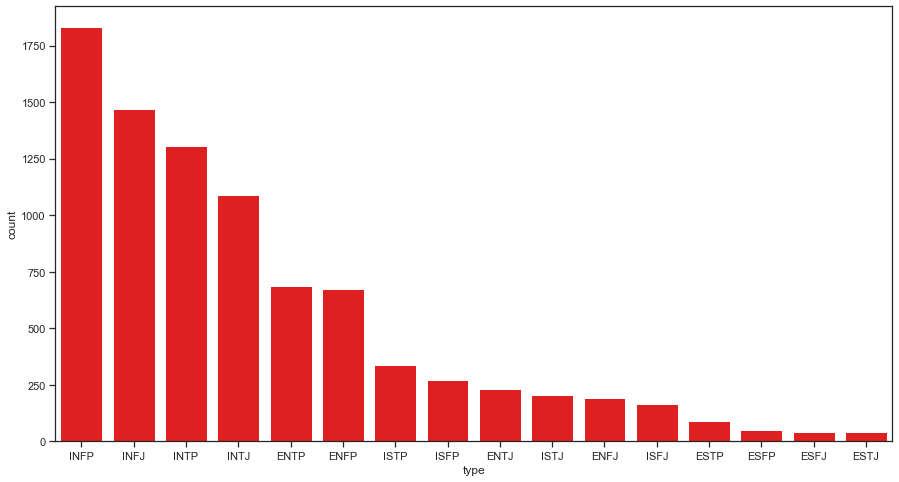

In [27]:
fig, ax = plt.subplots(figsize = (15,8))

sns.countplot(x='type', data=df, color='red', order=df.type.value_counts().index)

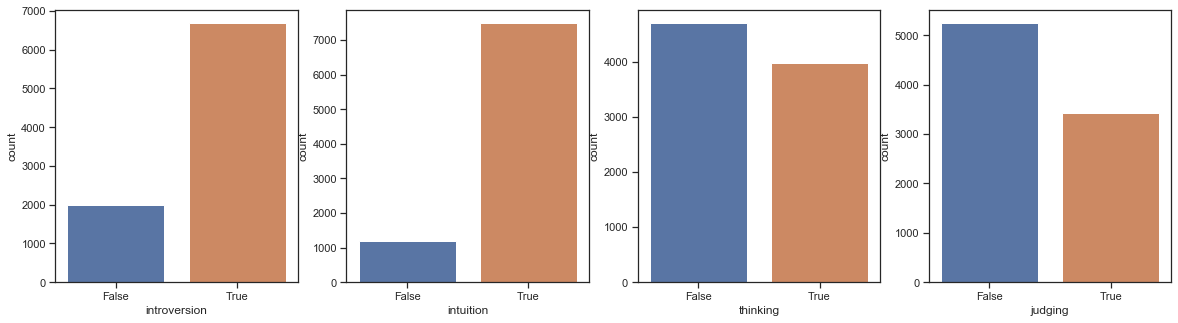

In [28]:
fig, axs = plt.subplots(1,4,figsize = (20,5))

sns.countplot(x='introversion', data= df[['introversion','intuition','thinking','judging']], ax=axs[0])
sns.countplot(x='intuition', data= df[['introversion','intuition','thinking','judging']], ax=axs[1])
sns.countplot(x='thinking', data= df[['introversion','intuition','thinking','judging']], ax=axs[2])
sns.countplot(x='judging', data= df[['introversion','intuition','thinking','judging']], ax=axs[3]);

For introversion and intuition, the data is very imbalanced.   
For thinking an judging, the data is a little bit of imbalanced. 

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 6 columns):
type            8675 non-null object
introversion    8675 non-null bool
intuition       8675 non-null bool
thinking        8675 non-null bool
judging         8675 non-null bool
tokens          8675 non-null object
dtypes: bool(4), object(2)
memory usage: 169.5+ KB


### oversampling the minority on 'Introversion'

In [30]:
from sklearn.utils import resample

In [31]:
# Separate majority and minority classes
df_majority = df[df.introversion==1]
df_minority = df[df.introversion==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6676,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_introversion = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_introversion.introversion.value_counts()

True     6676
False    6676
Name: introversion, dtype: int64

In [32]:
df_introversion.head()

type  introversion  intuition  thinking  judging  \
0  INFJ  True          True       False     True      
2  INTP  True          True       True      False     
3  INTJ  True          True       True      True      
5  INTJ  True          True       True      True      
6  INFJ  True          True       False     True      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [33]:
from sklearn.model_selection import train_test_split

X0 = df_introversion.tokens
y0 = df_introversion.introversion

X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size = 0.2, random_state=42)

### oversampling the minority on 'Intuition'

In [34]:
# Separate majority and minority classes
df_majority = df[df.intuition==True]
df_minority = df[df.intuition==False]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=7478,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_intuition = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_intuition.intuition.value_counts()

True     7478
False    7478
Name: intuition, dtype: int64

In [35]:
df_intuition.head(1)

,type,introversion,intuition,thinking,judging,tokens
0,INFJ,True,True,False,True,moment sportscent top ten play prank life chang experi life repeat today may perc experi immers last thing friend post facebook commit suicid next day rest peac hello sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth welcom stuff game set match prozac wellbrutin least thirti minut move leg mean move sit desk chair weed moder mayb tri edibl healthier altern basic come three item determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim dear favorit video game grow current favorit video game cool appear late sad someon everyon wait thought confid good thing cherish time solitud b c revel within inner world wherea time workin enjoy time worri peopl alway around yo ladi complimentari person well hey main social outlet xbox live convers even verbal fatigu quickli realli dig part ban thread requir get high backyard roast eat marshmellow backyard convers someth intellectu follow massag kiss ban mani b sentenc could think b ban watch movi corner dunc ban health class clearli taught noth peer pressur ban whole host reason two babi deer left right munch beetl middl use blood two caveman diari today latest happen design cave diari wall see pokemon world societi everyon becom optimist artist artist draw idea count form someth like signatur welcom robot rank person down self esteem cuz avid signatur artist like proud ban take room bed ya got ta learn share roach ban much thunder grumbl kind storm yep ahh old high school music heard age fail public speak class year ago sort learn could better posit big part failur overload like person mental confirm way move denver area start new life


In [36]:
## train test split on the intuition dataset

X1 = df_intuition.tokens
y1 = df_intuition.intuition

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state=42)

## No need to oversampling on 'thinking' and 'judging' 

In [37]:
X2 = df.tokens
y2 = df.thinking

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state=42)

In [38]:
X3 = df.tokens
y3 = df.judging

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.3, random_state=42)

### Now we have all the training and test datasets ready, let's inject them into some model pipelines!

In [79]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# Try 10 different models - LogisticRegression, RandomForest, GradientBoosting
# with either pure counts or tfidf features

lr = Pipeline([
        ("count vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("lr", LogisticRegression(solver='saga', random_state=42))
    ])

lr_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("lr", LogisticRegression(solver='saga', random_state=42))
    ])

rf = Pipeline([
        ("count vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("rf", RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42))
    ])

rf_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("rf", RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42))
    ])

xgb = Pipeline([
        ("count vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("xgb", XGBClassifier(eta=0.1, max_depth=5, seed=42))
    ])

xgb_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("xgb", XGBClassifier(eta=0.1, max_depth=5, seed=42))
    ])

sgd = Pipeline([
        ("count vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("sgd", SGDClassifier(loss="log"))
    ])
sgd_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("sgd", SGDClassifier(loss="log"))
    ])
 
svc = Pipeline([
        ("count_vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("linear svc", SVC(kernel="linear"))
    ])
svc_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("linear svc", SVC(kernel="linear"))
    ])
   
all_models = [
    ("lr", lr),
    ("lr_tfidf", lr_tfidf),
    ("rf", rf),
    ("rf_tfidf", rf_tfidf),
    ("xgb", xgb),
    ("xgb_tfidf", xgb_tfidf),
    ("sgd", sgd),
    ("sgd_tfidf", sgd_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ]

In [ ]:
unsorted_scores = [(name, cross_val_score(model, X_train0, y_train0, cv=5).mean()) for name, model in all_models]
scores0 = sorted(unsorted_scores, key=lambda x: -x[1])

In [84]:
print(scores0) 

[('xgb_tfidf', 0.8706115629912773), ('sgd', 0.8601248906812202), ('svc', 0.855256371159822), ('xgb', 0.8516067888933871), ('lr', 0.8286679408110007), ('svc_tfidf', 0.822207179023413), ('sgd_tfidf', 0.8179943531044781), ('lr_tfidf', 0.8165900777981665), ('rf_tfidf', 0.8085390454257867), ('rf', 0.7845718121417017)]


In [ ]:
unsorted_scores = [(name, cross_val_score(model, X_train1, y_train1, cv=5).mean()) for name, model in all_models]
scores1 = sorted(unsorted_scores, key=lambda x: -x[1])

In [85]:
print(scores1)

[('sgd', 0.9215971280550128), ('svc', 0.9149096320724859), ('xgb_tfidf', 0.9139930086135217), ('xgb', 0.895103848515831), ('lr', 0.8881641888873842), ('svc_tfidf', 0.8682705666576434), ('rf_tfidf', 0.8630068859141833), ('sgd_tfidf', 0.8625040255878101), ('lr_tfidf', 0.86208558119024), ('rf', 0.8438676235874825)]


In [ ]:
unsorted_scores = [(name, cross_val_score(model, X_train2, y_train2, cv=5).mean()) for name, model in all_models]
scores2 = sorted(unsorted_scores, key=lambda x: -x[1])

In [86]:
print(scores2)

[('lr_tfidf', 0.8134038195494337), ('sgd_tfidf', 0.8122498357433983), ('svc_tfidf', 0.8086483607710283), ('lr', 0.7958261201136908), ('xgb', 0.7786773732282627), ('xgb_tfidf', 0.7775193404950677), ('sgd', 0.7445254274502925), ('svc', 0.724786238298595), ('rf_tfidf', 0.7177268584418971), ('rf', 0.7131149707986376)]


In [ ]:
unsorted_scores = [(name, cross_val_score(model, X_train3, y_train3, cv=5).mean()) for name, model in all_models]
scores3 = sorted(unsorted_scores, key=lambda x: -x[1])

In [87]:
print(scores3)

[('lr_tfidf', 0.7160732469610375), ('xgb', 0.7155794198005438), ('sgd_tfidf', 0.7119551731852666), ('xgb_tfidf', 0.7099775594741731), ('svc_tfidf', 0.7065245659351463), ('lr', 0.6956515549047125), ('sgd', 0.6478921498837296), ('svc', 0.6398222384932983), ('rf', 0.601943444451224), ('rf_tfidf', 0.601943444451224)]


### For Introversion, SGDClassifier got the best result.

In [70]:
model0 = xgb_tfidf
model0.fit(X_train0, y_train0)
y_pred0 = model0.predict(X_test0)
y_prob0 = model0.predict_proba(X_test0)

print('The accuracy score is {}'.format(accuracy_score(y_test0, y_pred0)))
print('\n')
print(classification_report(y_test0, y_pred0, target_names = ['Extraversion', 'Introversion']))

The accuracy score is 0.883938599775365


              precision    recall  f1-score   support

Extraversion       0.88      0.89      0.89      1346
Introversion       0.89      0.87      0.88      1325

    accuracy                           0.88      2671
   macro avg       0.88      0.88      0.88      2671
weighted avg       0.88      0.88      0.88      2671



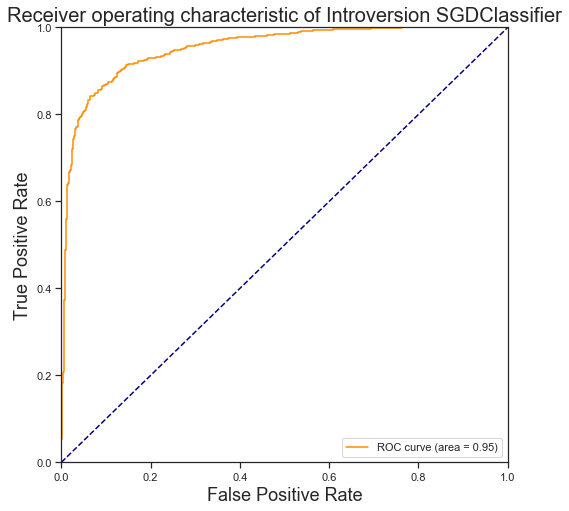

In [71]:
fpr, tpr, thresholds = roc_curve(y_test0, y_prob0[:,1])
roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots(figsize=(8,8))

plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic of Introversion SGDClassifier', fontsize=20)
plt.legend(loc="lower right")
plt.show();

### For Intuition, still SGDClassifier got the best result.

In [72]:
model1 = sgd
model1.fit(X_train1, y_train1)
y_pred1 = model1.predict(X_test1)
y_prob1 = model1.predict_proba(X_test1)

print('The accuracy score is {}'.format(accuracy_score(y_test1, y_pred1)))
print('\n')
print(classification_report(y_test1, y_pred1))

The accuracy score is 0.9288101604278075


              precision    recall  f1-score   support

       False       0.88      0.99      0.93      1470
        True       0.99      0.87      0.93      1522

    accuracy                           0.93      2992
   macro avg       0.94      0.93      0.93      2992
weighted avg       0.94      0.93      0.93      2992



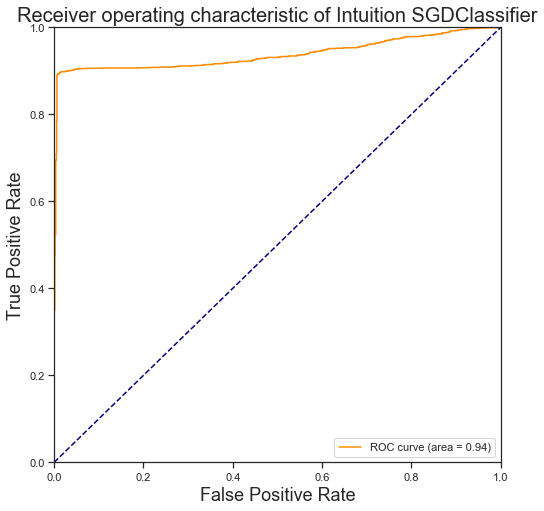

In [73]:
fpr, tpr, thresholds = roc_curve(y_test1, y_prob1[:,1])
roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots(figsize=(8,8))

plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic of Intuition SGDClassifier', fontsize=20)
plt.legend(loc="lower right")
plt.show();

### For thinking, Logistic Regression - tfidf and SVC got almost the same good results.

In [75]:
model2 = lr_tfidf
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)
y_prob2 = model2.predict_proba(X_test2)

print('The accuracy score is {}'.format(accuracy_score(y_test2, y_pred2)))
print('\n')
print(classification_report(y_test2, y_pred2))

The accuracy score is 0.8040345821325648


              precision    recall  f1-score   support

       False       0.81      0.84      0.82       937
        True       0.80      0.76      0.78       798

    accuracy                           0.80      1735
   macro avg       0.80      0.80      0.80      1735
weighted avg       0.80      0.80      0.80      1735



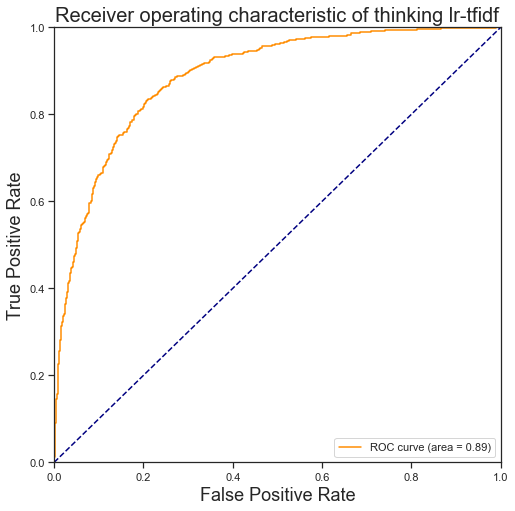

In [76]:
fpr, tpr, thresholds = roc_curve(y_test2, y_prob2[:,1])
roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots(figsize=(8,8))

plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic of thinking lr-tfidf', fontsize=20)
plt.legend(loc="lower right")
plt.show();

### For thinking, lr-tfidf got almost the same good results.

In [77]:
model3 = lr_tfidf
model3.fit(X_train3, y_train3)
y_pred3 = model3.predict(X_test3)
y_prob3 = model3.predict_proba(X_test3)

print('The accuracy score is {}'.format(accuracy_score(y_test3, y_pred3)))
print('\n')
print(classification_report(y_test3, y_pred3))

The accuracy score is 0.7283903188628505


              precision    recall  f1-score   support

       False       0.73      0.89      0.80      1586
        True       0.74      0.47      0.58      1017

    accuracy                           0.73      2603
   macro avg       0.73      0.68      0.69      2603
weighted avg       0.73      0.73      0.71      2603



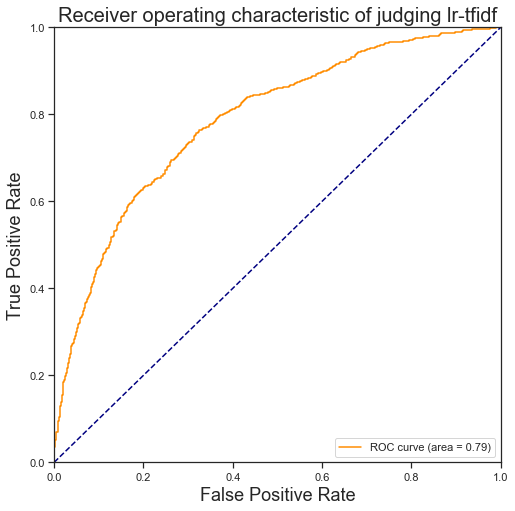

In [78]:
fpr, tpr, thresholds = roc_curve(y_test3, y_prob3[:,1])
roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots(figsize=(8,8))

plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic of judging lr-tfidf', fontsize=20)
plt.legend(loc="lower right")
plt.show();

# Applying the Model to okcupid dataset

In [91]:
df_ok = pd.read_csv('data/profiles.csv')

In [92]:
df_ok.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [93]:
df_ok = df_ok[[
    'essay0','essay1', 'essay2', 'essay3', 'essay4', 
    'essay5', 'essay6', 'essay7','essay8', 'essay9', 
    'orientation', 'sex']]

In [94]:
df_ok.head()

,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,orientation,sex
0,"about me:<br />\n<br />\ni would love to think that i was some some kind of intellectual:\neither the dumbest smart guy, or the smartest dumb guy. can't say i\ncan tell the difference. i love to talk about ideas and concepts. i\nforge odd metaphors instead of reciting cliches. like the\nsimularities between a friend of mine's house and an underwater\nsalt mine. my favorite word is salt by the way (weird choice i\nknow). to me most things in life are better as metaphors. i seek to\nmake myself a little better everyday, in some productively lazy\nway. got tired of tying my shoes. considered hiring a five year\nold, but would probably have to tie both of our shoes... decided to\nonly wear leather shoes dress shoes.<br />\n<br />\nabout you:<br />\n<br />\nyou love to have really serious, really deep conversations about\nreally silly stuff. you have to be willing to snap me out of a\nlight hearted rant with a kiss. you don't have to be funny, but you\nhave to be able to make me laugh. you should be able to bend spoons\nwith your mind, and telepathically make me smile while i am still\nat work. you should love life, and be cool with just letting the\nwind blow. extra points for reading all this and guessing my\nfavorite video game (no hints given yet). and lastly you have a\ngood attention span.","currently working as an international agent for a freight\nforwarding company. import, export, domestic you know the\nworks.<br />\nonline classes and trying to better myself in my free time. perhaps\na hours worth of a good book or a video game on a lazy sunday.","making people laugh.<br />\nranting about a good salting.<br />\nfinding simplicity in complexity, and complexity in simplicity.","the way i look. i am a six foot half asian, half caucasian mutt. it\nmakes it tough not to notice me, and for me to blend in.","books:<br />\nabsurdistan, the republic, of mice and men (only book that made me\nwant to cry), catcher in the rye, the prince.<br />\n<br />\nmovies:<br />\ngladiator, operation valkyrie, the producers, down periscope.<br />\n<br />\nshows:<br />\nthe borgia, arrested development, game of thrones, monty\npython<br />\n<br />\nmusic:<br />\naesop rock, hail mary mallon, george thorogood and the delaware\ndestroyers, felt<br />\n<br />\nfood:<br />\ni'm down for anything.",food.<br />\nwater.<br />\ncell phone.<br />\nshelter.,duality and humorous things,trying to find someone to hang out with. i am down for anything\nexcept a club.,i am new to california and looking for someone to wisper my secrets\nto.,you want to be swept off your feet!<br />\nyou are tired of the norm.<br />\nyou want to catch a coffee or a bite.<br />\nor if you want to talk philosophy.,straight,m
1,i am a chef: this is what that means.<br />\n1. i am a workaholic.<br />\n2. i love to cook regardless of whether i am at work.<br />\n3. i love to drink and eat foods that are probably really bad for\nme.<br />\n4. i love being around people that resemble line 1-3.<br />\ni love the outdoors and i am an avid skier. if its snowing i will\nbe in tahoe at the very least. i am a very confident and friendly.\ni'm not interested in acting or being a typical guy. i have no time\nor patience for rediculous acts of territorial pissing. overall i\nam a very likable easygoing individual. i am very adventurous and\nalways looking forward to doing new things and hopefully sharing it\nwith the right person.,dedicating everyday to being an unbelievable badass.,being silly. having ridiculous amonts of fun wherever. being a\nsmart ass. ohh and i can cook. ;),NaN,i am die hard christopher moore fan. i don't really watch a lot of\ntv unless there is humor involved. i am kind of stuck on 90's\nalternative music. i am pretty much a fan of everything though... i\ndo need to draw a line at most types of electronica.,delicious porkness in all of its glories.<br />\nmy big ass doughboy's sinki

In [95]:
def clean_text(text):
    '''
    clean the text data: split the text, remove the redundant signs and words.
    '''
    text = text.replace('<br />', ' ')
    text = text.replace('\n', ' ')
    words = nltk.word_tokenize(text)   #split the text into words
    words = [word for word in words if word.isalpha()]    #remove the non-alphabetic signs
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in set(stop_words)]   #remove the stop words
    return words

def clean_text_column(df, col_name):
    '''
    input a dataframe and one of its column, the function clean the text within
    the column.
    '''
    df_ = df[df[col_name].notnull()]
    df[col_name] = df_.apply(lambda row: clean_text(row[col_name]), axis = 1)

In [96]:
clean_text_column(df_ok, 'essay0')
clean_text_column(df_ok, 'essay1')
clean_text_column(df_ok, 'essay2')
clean_text_column(df_ok, 'essay3')
clean_text_column(df_ok, 'essay4')
clean_text_column(df_ok, 'essay5')
clean_text_column(df_ok, 'essay6')
clean_text_column(df_ok, 'essay7')
clean_text_column(df_ok, 'essay8')
clean_text_column(df_ok, 'essay9')

In [97]:
cols = ['essay0','essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7','essay8', 'essay9']
df_ok['statement'] = df_ok[cols].apply(lambda row: ', '.join(row.astype(str)), axis=1)

In [98]:
df_ok.drop(['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
            'essay6', 'essay7', 'essay8', 'essay9'], axis=1, inplace=True)

In [99]:
oktoken_filtered = df_ok.statement.apply(lambda x: clean_data(x))

In [100]:
oktoken_filtered.apply(lambda x: x[0])

0        would love think kind intellectu either dumbest smart guy smartest dumb guy ca say tell differ love talk idea concept forg odd metaphor instead recit clich like simular friend mine hous underwat salt mine favorit word salt way weird choic know thing life better metaphor seek make littl better everyday product lazi way got tire tie shoe consid hire five year old would probabl tie shoe decid wear leather shoe dress shoe love realli seriou realli deep convers realli silli stuff will snap light heart rant kiss funni abl make laugh abl bend spoon mind telepath make smile still work love life cool let wind blow extra point read guess favorit video game hint given yet lastli good attent span current work intern agent freight forward compani import export domest know work onlin class tri better free time perhap hour worth good book video game lazi sunday make peopl laugh rant good salt find simplic complex complex simplic way look six foot half asian half caucasian mutt make tough not

In [101]:
df_ok['statement'] = oktoken_filtered

In [102]:
df_ok.statement[0][0]

'would love think kind intellectu either dumbest smart guy smartest dumb guy ca say tell differ love talk idea concept forg odd metaphor instead recit clich like simular friend mine hous underwat salt mine favorit word salt way weird choic know thing life better metaphor seek make littl better everyday product lazi way got tire tie shoe consid hire five year old would probabl tie shoe decid wear leather shoe dress shoe love realli seriou realli deep convers realli silli stuff will snap light heart rant kiss funni abl make laugh abl bend spoon mind telepath make smile still work love life cool let wind blow extra point read guess favorit video game hint given yet lastli good attent span current work intern agent freight forward compani import export domest know work onlin class tri better free time perhap hour worth good book video game lazi sunday make peopl laugh rant good salt find simplic complex complex simplic way look six foot half asian half caucasian mutt make tough notic blend

### Let's apply the models to this bag_of_words, and predict each user's mbti personality!

### 1. Apply model0 to get 'introversion' types

In [103]:
model0 = sgd
model0.fit(X_train0, y_train0)

y_ok0 = model0.predict_proba(oktoken_filtered.apply(lambda x: x[0]))

In [104]:
(y_ok0[:, 1] > 0.4).mean()

0.6981116338037567

### 2. Apply model1 to get 'intuition' types

In [105]:
model1 = sgd
model1.fit(X_train1, y_train1)

y_ok1 = model1.predict_proba(oktoken_filtered.apply(lambda x: x[0]))

In [106]:
(y_ok1[:, 1] > 0.4).mean()

0.5503453107797017

### 3. Apply model2 to get 'thinking' types

In [107]:
model2 = sgd_tfidf
model2.fit(X_train2, y_train2)

y_ok2 = model2.predict_proba(oktoken_filtered.apply(lambda x: x[0]))

In [108]:
(y_ok2[:, 1] > 0.4).mean()

0.5999733093117139

### 4. Apply model3 to get 'judging' types

In [109]:
model3 = lr_tfidf
model3.fit(X_train3, y_train3)

y_ok3 = model3.predict_proba(oktoken_filtered.apply(lambda x: x[0]))

In [110]:
(y_ok3[:, 1] > 0.4).mean()

0.20064724919093851

## Get the MBTI personalities for all the users!


                        |           | Subjective        | Objective                 |
                        |-----------|-------------------|---------------------------|
                        | Deductive | Intuition/Sensing | Introversion/Extraversion |
                        | Inductive | Feeling/Thinking  | Perception/Judging        |

In [111]:
mbti_arr = np.stack([y_ok0[:, 1] > 0.4, y_ok1[:, 1] > 0.4, y_ok2[:, 1] > 0.4, y_ok3[:, 1] > 0.4], axis=1)

In [112]:
def get_mbti(arr):
    '''
    input: 4 binary ndarray (nparray)
    output: mbti personality (string)
    '''
    a, b, c, d = '', '', '', ''
    if arr[0] == 1:
        a = 'I'
    else:
        a = 'E'
    
    if arr[1] == 1:
        b = 'N'
    else:
        b = 'S'
        
    if arr[2] == 1:
        c = 'T'
    else:
        c = 'F'
        
    if arr[3] == 1:
        d = 'J'
    else:
        d = 'P'
    return a+b+c+d

In [113]:
mbti_arr

array([[ True,  True,  True, False],
       [False, False, False, False],
       [ True,  True,  True,  True],
       ...,
       [ True, False,  True, False],
       [ True, False, False, False],
       [False,  True,  True, False]])

In [114]:
df_ok['mbti_type'] = np.apply_along_axis(get_mbti, 1, mbti_arr)

In [115]:
df_match = df_ok[['orientation', 'sex', 'mbti_type']]

In [116]:
df_match.head()

,orientation,sex,mbti_type
0,straight,m,INTP
1,straight,m,ESFP
2,straight,m,INTJ
3,straight,m,INTJ
4,straight,m,ESFP


Text(0.5, 1.0, 'okcupid user mbit personality count')

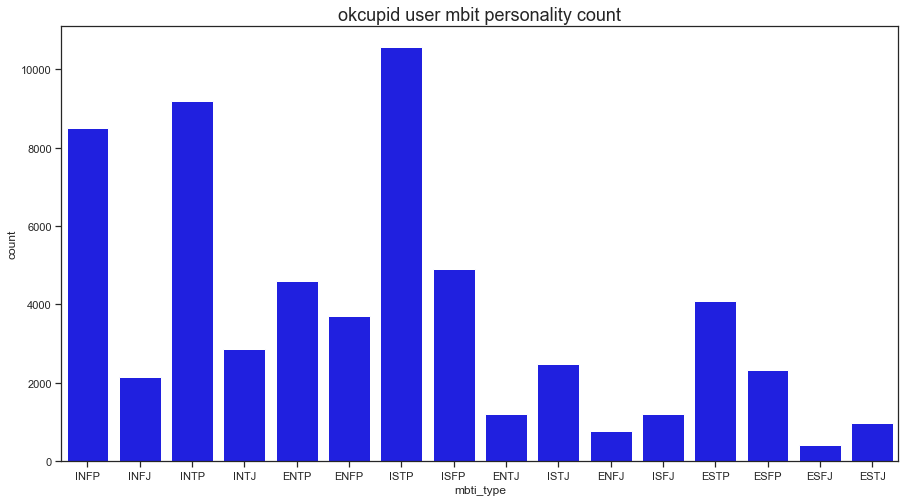

In [117]:
fig, ax = plt.subplots(figsize = (15,8))

sns.countplot(x='mbti_type', data=df_match, color='blue', order=df.type.value_counts().index)
ax.set_title('okcupid user mbit personality count', fontsize=18)

In [118]:
df_percentage = (df.groupby('type').count() / df.count()[0])['tokens']
df_match_percentage = df_match.groupby('mbti_type').count()['sex'] / df_match.count()[0]

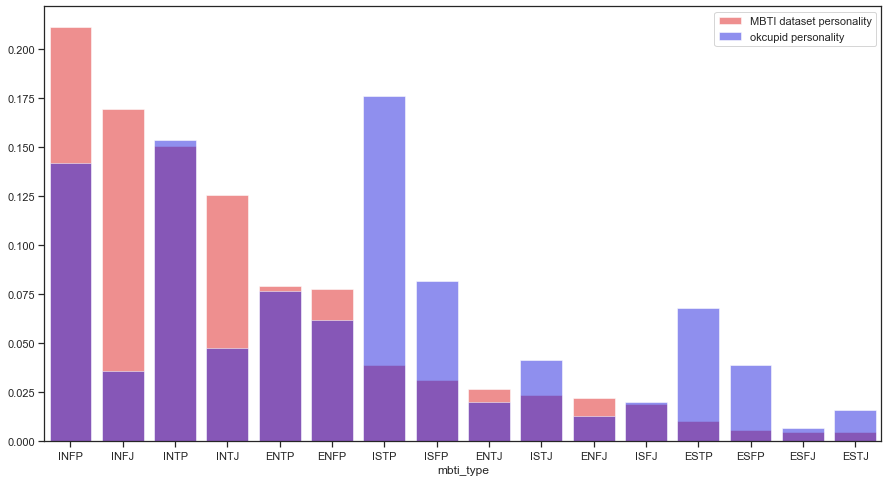

In [119]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(df_percentage.index, df_percentage.values, color='red',
            alpha=0.5, order=df.type.value_counts().index, label='MBTI dataset personality')
sns.barplot(df_match_percentage.index, df_match_percentage.values,
            color='blue', alpha=0.5, order=df.type.value_counts().index, label='okcupid personality')
ax.legend();

In [120]:
personalities = ['ENTJ', 'ENTP', 'INTJ', 'INTP', 'ESTJ', 'ESFJ',
                 'ISTJ', 'ISFJ', 'ENFJ', 'ENFP', 'INFJ', 'INFP', 'ESTP', 'ESFP', 'ISTP', 'ISFP']

In [121]:
score = np.linspace(1, 10, 5)
score

array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])

In [122]:
mask = np.array([[0,1,2,2,1,0,1,0,1,2,2,4,3,3,2,4],
 [1,3,2,2,3,3,4,4,3,2,3,3,1,0,1,0],
 [2,2,2,1,1,0,2,0,2,2,2,3,4,4,2,3],
 [2,2,1,2,3,4,2,4,4,2,3,1,1,0,1,0],
 [1,3,1,3,2,1,2,2,0,2,0,4,0,2,2,4],
 [0,3,0,4,1,2,2,2,2,3,1,2,2,1,4,2],
 [1,4,2,2,2,2,2,1,0,4,0,3,2,2,1,3],
 [0,4,0,4,2,2,1,1,1,4,1,2,2,2,3,0],
 [1,2,2,4,0,2,0,1,3,1,2,2,3,3,4,2],
 [2,1,2,2,3,3,4,4,1,2,2,1,0,0,0,1],
 [2,2,2,3,0,1,0,1,2,2,2,0,4,4,4,2],
 [4,2,3,1,4,2,3,2,2,1,0,2,0,1,1,1],
 [3,1,4,1,0,2,2,2,3,0,4,0,2,1,2,2],
 [3,0,4,0,2,1,2,2,3,0,4,1,1,1,2,2],
 [2,1,2,1,2,4,1,3,4,0,4,0,2,2,1,1],
 [4,0,3,0,4,2,3,0,2,2,2,1,2,2,1,2]])

In [123]:
matching_scores = pd.DataFrame(score[mask], index=personalities, columns=personalities)

In [124]:
matching_scores

,ENTJ,ENTP,INTJ,INTP,ESTJ,ESFJ,ISTJ,ISFJ,ENFJ,ENFP,INFJ,INFP,ESTP,ESFP,ISTP,ISFP
ENTJ,1.00,3.25,5.50,5.50,3.25,1.00,3.25,1.00,3.25,5.50,5.50,10.00,7.75,7.75,5.50,10.00
ENTP,3.25,7.75,5.50,5.50,7.75,7.75,10.00,10.00,7.75,5.50,7.75,7.75,3.25,1.00,3.25,1.00
INTJ,5.50,5.50,5.50,3.25,3.25,1.00,5.50,1.00,5.50,5.50,5.50,7.75,10.00,10.00,5.50,7.75
INTP,5.50,5.50,3.25,5.50,7.75,10.00,5.50,10.00,10.00,5.50,7.75,3.25,3.25,1.00,3.25,1.00
ESTJ,3.25,7.75,3.25,7.75,5.50,3.25,5.50,5.50,1.00,5.50,1.00,10.00,1.00,5.50,5.50,10.00
ESFJ,1.00,7.75,1.00,10.00,3.25,5.50,5.50,5.50,5.50,7.75,3.25,5.50,5.50,3.25,10.00,5.50
ISTJ,3.25,10.00,5.50,5.50,5.50,5.50,5.50,3.25,1.00,10.00,1.00,7.75,5.50,5.50,3.25,7.75
ISFJ,1.00,10.00,1.00,10.00,5.50,5.50,3.25,3.25,3.25,10.00,3.25,5.50,5.50,5.50,7.75,1.00
ENFJ,3.25,5.50,5.50,10.00,1.00,5.50,1.00,3.25,7.75,3.25,5.50,5.50,7.75,7.75,10.00,5.50
ENFP,5.50,3.25,5.50,5.50,7.75,7.75,10.00,10.00,3.25,5.50,5.50,3.25,1.00,1.00,1.00,3.25


### Now let's do the matching for the people!!!

<img src="images/mbti.jpeg" style="height:800px"> 

In [125]:
def get_the_top_matches(df, idx):
    score_sort = matching_scores[df_match.iloc[idx]['mbti_type']].sort_values(
        ascending=False).to_frame().reset_index()
    score_sort.columns = ['mbti_type', 'score']
    
    sex = df_match.iloc[idx]['sex']
    orientation = df_match.iloc[idx]['orientation']
    mbti_type = df_match.iloc[idx]['mbti_type']
    
    if orientation == 'straight':
        matched = df[(df['sex'] != sex) & (df_match['orientation'] == orientation)]
    else:
        matched = df[(df['sex'] == sex) & (df_match['orientation'] == orientation)]
    
    result = matched.merge(score_sort, on = 'mbti_type').sort_values(by='score', ascending=False)
    return print('Your MBTI type is {}'.format(mbti_type)), print('\n'), print('Your top matches are: \n\n {}'.format(result[:50]))

In [126]:
get_the_top_matches(df_match, 100)

Your MBTI type is INFP


Your top matches are: 

       orientation sex mbti_type  score
12982  straight    f   ENTJ      10.0 
12895  straight    f   ENTJ      10.0 
12897  straight    f   ENTJ      10.0 
12898  straight    f   ENTJ      10.0 
12899  straight    f   ENTJ      10.0 
12900  straight    f   ENTJ      10.0 
12901  straight    f   ENTJ      10.0 
12902  straight    f   ENTJ      10.0 
12903  straight    f   ENTJ      10.0 
12904  straight    f   ENTJ      10.0 
12905  straight    f   ENTJ      10.0 
12906  straight    f   ENTJ      10.0 
12907  straight    f   ENTJ      10.0 
12908  straight    f   ENTJ      10.0 
12909  straight    f   ENTJ      10.0 
12910  straight    f   ENTJ      10.0 
12911  straight    f   ENTJ      10.0 
12912  straight    f   ENTJ      10.0 
12913  straight    f   ENTJ      10.0 
12914  straight    f   ENTJ      10.0 
12915  straight    f   ENTJ      10.0 
12916  straight    f   ENTJ      10.0 
12917  straight    f   ENTJ      10.0 
12896  straigh

(None, None, None)